#Dataset Overview

The PBJ Staffing Data provides daily staffing levels for nursing homes, tracking nurse hours, resident census, and contract vs. full-time staff utilization. The Provider Information Dataset adds facility ownership details, regulatory citations, and financial penalties.

By combining both datasets, we can identify understaffed facilities at risk of CMS non-compliance, track financial penalties, and detect inefficient workforce management. Insights include repeat violators, facilities with high staffing deviations, and those underutilizing contract staffing despite chronic shortages.

This integration helps Clipboard Health target facilities struggling with compliance, staffing instability, and high fines, offering tailored solutions to optimize workforce planning, avoid penalties, and improve operational efficiency.


In [ ]:
import requests
from io import StringIO
import pandas as pd
import gdown

file_id_pbj = "1ztIJ988vYdizyAR88WKUQ3F6NaW79_tB"
pbj_file_path = "PBJ_Daily_Nurse_Staffing_Q2_2024.csv"
gdown.download(f"https://drive.google.com/uc?id={file_id_pbj}", pbj_file_path, quiet=False)
df_pbj = pd.read_csv(pbj_file_path, encoding="ISO-8859-1")

orig_url_provider="https://drive.google.com/file/d/1VLVU6L9LPCGdnSt67Aobaj0MCYcO7Gz6/view"

file_id_provider = orig_url_provider.split('/')[-2]
dwn_url_provider='https://drive.google.com/uc?export=download&id=' + file_id_provider
url_provider = requests.get(dwn_url_provider).text
csv_raw_provider = StringIO(url_provider)
df_provider = pd.read_csv(csv_raw_provider)

# Show first few rows of both datasets
print("PBJ Staffing Data:")
print(df_pbj.head())
print("--------------------------------------")

print("\nProvider Information Data:")
print(df_provider.head())
print("--------------------------------------")

print(df_provider.shape)
print("--------------------------------------")
print(df_pbj.shape)

Downloading...
From (original): https://drive.google.com/uc?id=1ztIJ988vYdizyAR88WKUQ3F6NaW79_tB
From (redirected): https://drive.google.com/uc?id=1ztIJ988vYdizyAR88WKUQ3F6NaW79_tB&confirm=t&uuid=f1659026-2e15-4dbe-bae6-326e92f3495c
To: /content/PBJ_Daily_Nurse_Staffing_Q2_2024.csv
100%|██████████| 220M/220M [00:01<00:00, 121MB/s]
<ipython-input-5-83f4bc3c7613>:9: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_pbj = pd.read_csv(pbj_file_path, encoding="ISO-8859-1")


PBJ Staffing Data:
  PROVNUM                  PROVNAME          CITY STATE COUNTY_NAME  \
0   15009  BURNS NURSING HOME, INC.  RUSSELLVILLE    AL    Franklin   
1   15009  BURNS NURSING HOME, INC.  RUSSELLVILLE    AL    Franklin   
2   15009  BURNS NURSING HOME, INC.  RUSSELLVILLE    AL    Franklin   
3   15009  BURNS NURSING HOME, INC.  RUSSELLVILLE    AL    Franklin   
4   15009  BURNS NURSING HOME, INC.  RUSSELLVILLE    AL    Franklin   

   COUNTY_FIPS  CY_Qtr  WorkDate  MDScensus  Hrs_RNDON  ...  Hrs_LPN_ctr  \
0           59  2024Q2  20240401         51      10.77  ...          0.0   
1           59  2024Q2  20240402         52       8.43  ...          0.0   
2           59  2024Q2  20240403         53      11.13  ...          0.0   
3           59  2024Q2  20240404         52      12.27  ...          0.0   
4           59  2024Q2  20240405         52       4.95  ...          0.0   

   Hrs_CNA  Hrs_CNA_emp  Hrs_CNA_ctr  Hrs_NAtrn  Hrs_NAtrn_emp  Hrs_NAtrn_ctr  \
0   160.08      

In [ ]:
df_provider.rename(columns={"CMS Certification Number (CCN)": "PROVNUM"}, inplace=True)

In [ ]:
df_pbj.rename(columns={"STATE": "PBJ_State"}, inplace=True)

In [ ]:
# Convert WorkDate to string first, then to datetime
df_pbj["WorkDate"] = pd.to_datetime(df_pbj["WorkDate"].astype(str), format="%Y%m%d", errors="coerce")

In [ ]:
def normalize_provnum(value):
    if isinstance(value, (int, float)):
        return str(int(value)).zfill(6)  # Convert number to string & zero-pad
    elif isinstance(value, str) and value.replace(".", "").isdigit():
        return str(int(float(value))).zfill(6)  # Handle string versions of numbers
    return value  # Keep alphanumeric values unchanged

# Apply the function
df_pbj["PROVNUM"] = df_pbj["PROVNUM"].astype(str).apply(normalize_provnum)
df_provider["PROVNUM"] = df_provider["PROVNUM"].astype(str).apply(normalize_provnum)

# Merge datasets
df_merged = df_pbj.merge(df_provider, on="PROVNUM", how="left")

# Check missing values again
print("Missing Values:")
print(df_merged[["State", "Provider Type"]].isnull().sum())

# Check sample merged dataset
print(df_merged.head())
print(f"Shape of merged dataset: {df_merged.shape}")


Missing Values:
State            2912
Provider Type    2912
dtype: int64
  PROVNUM                  PROVNAME          CITY PBJ_State COUNTY_NAME  \
0  015009  BURNS NURSING HOME, INC.  RUSSELLVILLE        AL    Franklin   
1  015009  BURNS NURSING HOME, INC.  RUSSELLVILLE        AL    Franklin   
2  015009  BURNS NURSING HOME, INC.  RUSSELLVILLE        AL    Franklin   
3  015009  BURNS NURSING HOME, INC.  RUSSELLVILLE        AL    Franklin   
4  015009  BURNS NURSING HOME, INC.  RUSSELLVILLE        AL    Franklin   

   COUNTY_FIPS  CY_Qtr   WorkDate  MDScensus  Hrs_RNDON  ...  \
0           59  2024Q2 2024-04-01         51      10.77  ...   
1           59  2024Q2 2024-04-02         52       8.43  ...   
2           59  2024Q2 2024-04-03         53      11.13  ...   
3           59  2024Q2 2024-04-04         52      12.27  ...   
4           59  2024Q2 2024-04-05         52       4.95  ...   

   Number of Citations from Infection Control Inspections  Number of Fines  \
0            

In [ ]:
# If provider `State` is missing, fill with PBJ `State`
df_merged["State"] = df_merged["State"].fillna(df_merged["PBJ_State"])

# Drop PBJ_State column if no longer needed
df_merged.drop(columns=["PBJ_State"], inplace=True)

# Check final missing values
print("Final Missing Values:")
print(df_merged[["State", "Provider Type"]].isnull().sum())

Final Missing Values:
State               0
Provider Type    2912
dtype: int64


In [ ]:
df_merged = df_merged.dropna(subset=["State", "Provider Type"])

# Confirm the new shape
print(f"Dataset after dropping missing provider rows: {df_merged.shape[0]} rows")

Dataset after dropping missing provider rows: 1322412 rows


In [ ]:
# Find unmatched PROVNUMs
missing_providers = set(df_pbj["PROVNUM"].unique()) - set(df_provider["PROVNUM"].unique())

# Display total unmatched PROVNUMs
print(f"Total PROVNUMs missing from provider dataset: {len(missing_providers)}")

# Show a sample of unmatched PROVNUMs
print("Sample of missing PROVNUMs:", list(missing_providers)[:10])


Total PROVNUMs missing from provider dataset: 32
Sample of missing PROVNUMs: ['395068', '3.0000000000000003e+77', '265384', '275026', '2.8999999999999997e+38', '235301', '205118', '265561', '245395', '3e+63']


# Data Transformation

In [ ]:
# Check missing values in PBJ
missing_values = df_pbj.isnull().sum()
missing_values = missing_values[missing_values > 0]  # Show only columns with missing values
print("🔍 Missing Values in Dataset:\n", missing_values)

🔍 Missing Values in Dataset:
 Series([], dtype: int64)


In [ ]:
# Check missing values in provider
missing_values = df_provider.isnull().sum()
missing_values = missing_values[missing_values > 0]  # Show only columns with missing values
print("🔍 Missing Values in Dataset:\n", missing_values)

🔍 Missing Values in Dataset:
 Average Number of Residents per Day                          50
Average Number of Residents per Day Footnote              14757
Affiliated Entity Name                                     4883
Affiliated Entity ID                                       4883
Special Focus Status                                      14279
                                                          ...  
Rating Cycle 3 Health Revisit Score                         142
Rating Cycle 3 Total Health Score                           142
Total Weighted Health Survey Score                           56
Number of Citations from Infection Control Inspections     7942
Geocoding Footnote                                        14010
Length: 72, dtype: int64


In [ ]:
empty_rows = df_pbj.isnull().all(axis=1).sum()
print(f"Completely empty rows: {empty_rows}")

Completely empty rows: 0


In [ ]:
df_merged["WorkDate"] = df_merged["WorkDate"].ffill()

In [ ]:
df_merged["MDScensus"] = df_merged["MDScensus"].fillna(df_merged["MDScensus"].mean())

In [ ]:
columns_to_drop = [
    "Average Number of Residents per Day Footnote",  # 14,757 missing
    "Geocoding Footnote",  # 14,010 missing
    "Affiliated Entity Name",  # 4,883 missing
    "Affiliated Entity ID",  # 4,883 missing
    "Special Focus Status",  # 14,279 missing
    "Rating Cycle 1 Health Revisit Score",  # 142 missing
    "Rating Cycle 1 Total Health Score",  # 142 missing
    "Rating Cycle 2 Health Revisit Score",  # 142 missing
    "Rating Cycle 2 Total Health Score",  # 142 missing
    "Rating Cycle 3 Health Revisit Score",  # 142 missing
    "Rating Cycle 3 Total Health Score",  # 142 missing
    "Number of Citations from Infection Control Inspections"  # 7,942 missing
]

df_provider_cleaned = df_provider.drop(columns=columns_to_drop, errors="ignore")
df_merged = df_merged.drop(columns=columns_to_drop, errors="ignore")
print("Dropped unnecessary columns.")


Dropped unnecessary columns.


In [ ]:
#Average Number of Residents per Day is an important metric but has only 50 missing values, use median imputation:

df_merged["Average Number of Residents per Day"] = df_merged["Average Number of Residents per Day"].fillna(df_merged["Average Number of Residents per Day"].median())

In [ ]:
df_merged.shape

(1322412, 122)

In [ ]:
pd.set_option("display.max_rows", None)  # Show all rows
print(df_merged.dtypes)
pd.reset_option("display.max_rows")  # Reset after printing

PROVNUM                                                                          object
PROVNAME                                                                         object
CITY                                                                             object
COUNTY_NAME                                                                      object
COUNTY_FIPS                                                                       int64
CY_Qtr                                                                           object
WorkDate                                                                 datetime64[ns]
MDScensus                                                                         int64
Hrs_RNDON                                                                       float64
Hrs_RNDON_emp                                                                   float64
Hrs_RNDON_ctr                                                                   float64
Hrs_RNadmin                     

In [ ]:
#Convert Data Types Correctly

# Convert WorkDate to datetime
date_cols = [
    "Rating Cycle 1 Standard Survey Health Date",
    "Rating Cycle 2 Standard Health Survey Date",
    "Rating Cycle 3 Standard Health Survey Date",
    "Processing Date",
    "Date First Approved to Provide Medicare and Medicaid Services"
]
for col in date_cols:
    df_merged[col] = pd.to_datetime(df_merged[col], errors="coerce")

# Convert ZIP Code, Telephone Number, and Provider SSA County Code to string
df_merged["ZIP Code"] = df_merged["ZIP Code"].astype("Int64").astype("string")  # Keep leading zeros
df_merged["Telephone Number"] = df_merged["Telephone Number"].astype("Int64").astype("string")
df_merged["Provider SSA County Code"] = df_merged["Provider SSA County Code"].astype("Int64").astype("string")

# Round Latitude and Longitude to 6 decimal places
df_merged["Latitude"] = df_merged["Latitude"].round(6)
df_merged["Longitude"] = df_merged["Longitude"].round(6)

print("Data types corrected successfully!")

Data types corrected successfully!


In [ ]:
print(df_merged.dtypes)

PROVNUM                              object
PROVNAME                             object
CITY                                 object
COUNTY_NAME                          object
COUNTY_FIPS                           int64
                                  ...      
Total Number of Penalties           float64
Location                             object
Latitude                            float64
Longitude                           float64
Processing Date              datetime64[ns]
Length: 122, dtype: object


In [ ]:
print("Data Types Summary:\n", df_merged.dtypes.value_counts())

Data Types Summary:
 float64           90
object            21
datetime64[ns]     6
string[python]     3
int64              2
Name: count, dtype: int64


In [ ]:
duplicate_rows = df_merged.duplicated().sum()
print(f"Duplicate rows found: {duplicate_rows}")

Duplicate rows found: 0


In [ ]:
# Ensure calculations modify the full DataFrame
df_merged.loc[:, "HPRD"] = (df_merged["Hrs_RNDON"] + df_merged["Hrs_LPN"] + df_merged["Hrs_CNA"]) / df_merged["MDScensus"]
df_merged.loc[:, "CNA_HPRD"] = df_merged["Hrs_CNA"] / df_merged["MDScensus"]

# Apply CMS-based exclusion filters with .copy()
df_filtered = df_merged[
    (df_merged["HPRD"] >= 1.5) &
    (df_merged["HPRD"] <= 12) &
    (df_merged["CNA_HPRD"] <= 5.25)
].copy()

print(f"Facilities after exclusion criteria: {df_filtered.shape[0]} rows")

Facilities after exclusion criteria: 1290455 rows


In [ ]:
numeric_cols = ["MDScensus", "Hrs_RNDON", "Hrs_LPN", "Hrs_CNA"]
print(df_filtered[numeric_cols].describe(percentiles=[0.01, 0.99]))

          MDScensus     Hrs_RNDON       Hrs_LPN       Hrs_CNA
count  1.290455e+06  1.290455e+06  1.290455e+06  1.290455e+06
mean   8.387944e+01  5.253934e+00  6.734453e+01  1.768909e+02
std    4.907202e+01  4.362094e+00  4.826249e+01  1.146053e+02
min    1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
1%     1.600000e+01  0.000000e+00  0.000000e+00  3.461000e+01
50%    7.600000e+01  8.000000e+00  5.800000e+01  1.531900e+02
99%    2.620000e+02  1.600000e+01  2.336300e+02  6.018192e+02
max    7.420000e+02  1.039600e+02  6.050000e+02  1.758100e+03


In [ ]:
df_filtered = df_filtered[
    (df_filtered["MDScensus"] > 0) |
    (df_filtered["Hrs_RNDON"] > 0) |
    (df_filtered["Hrs_LPN"] > 0) |
    (df_filtered["Hrs_CNA"] > 0)
].copy()

In [ ]:
print("Facilities after removing those with zero nurse staffing:", df_filtered.shape[0])

# Double-check if any zero staffing facilities still exist
remaining_zero_staffing = df_filtered[
    (df_filtered["Hrs_RNDON"] == 0) &
    (df_filtered["Hrs_LPN"] == 0) &
    (df_filtered["Hrs_CNA"] == 0)
]

print("Facilities still reporting zero staffing:", remaining_zero_staffing.shape[0])


Facilities after removing those with zero nurse staffing: 1290455
Facilities still reporting zero staffing: 0


In [ ]:
df_filtered["Total_Nurse_Hours"] = df_filtered["Hrs_RNDON"] + df_filtered["Hrs_RNadmin"]+ + df_filtered["Hrs_RN"] + df_filtered["Hrs_LPN"] + df_filtered["Hrs_LPNadmin"] + df_filtered["Hrs_MedAide"] + df_filtered["Hrs_NAtrn"]+ df_filtered["Hrs_CNA"]

print("Facilities still reporting zero staffing:", df_filtered[df_filtered["Total_Nurse_Hours"] == 0].shape[0])
print("Facilities with Total Nurse Hours < 1 after filtering:", df_filtered[df_filtered["Total_Nurse_Hours"] < 1].shape[0])

Facilities still reporting zero staffing: 0
Facilities with Total Nurse Hours < 1 after filtering: 0


#EDA

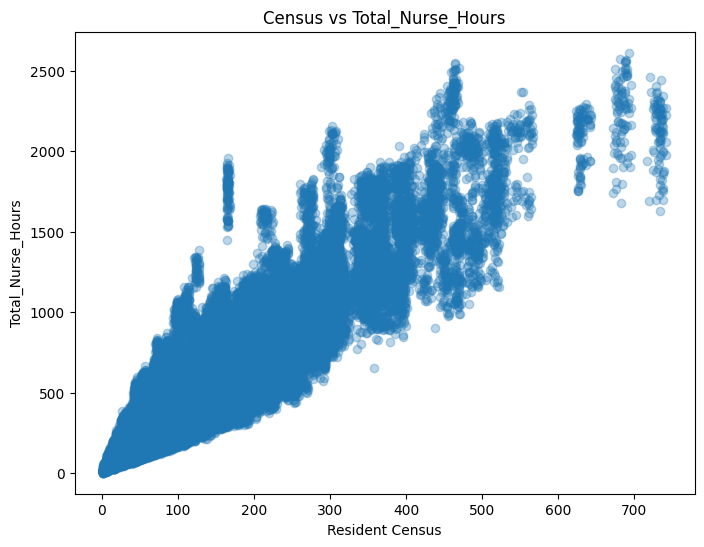

In [ ]:
import matplotlib.pyplot as plt

# Scatter plot to see the relationship between facility size and nurse hours
plt.figure(figsize=(8,6))
plt.scatter(df_filtered["MDScensus"], df_filtered["Total_Nurse_Hours"], alpha=0.3)
plt.xlabel("Resident Census")
plt.ylabel("Total_Nurse_Hours")
plt.title("Census vs Total_Nurse_Hours")
plt.show()

In [ ]:
df_filtered["Total_Nurse__HPRD"] = df_filtered["Total_Nurse_Hours"] / df_filtered["MDScensus"]

# Identify facilities with extremely high CNA Hours Per Resident Day
high_total_nurse_facilities = df_filtered[df_filtered["Total_Nurse__HPRD"] > 12]  # Normally 2-5 is standard

print("Facilities with extremely high Total Nurse hours per resident per day:", high_total_nurse_facilities.shape[0])

Facilities with extremely high Total Nurse hours per resident per day: 372


In [ ]:
df_filtered["Facility_Size"] = pd.cut(df_filtered["MDScensus"], bins=[0, 200, 400, 600, 800], labels=["Small", "Medium", "Large", "Very Large"])

# Calculate average CNA hours per group
staffing_by_size = df_filtered.groupby("Facility_Size")["Total_Nurse_Hours"].mean()
print(staffing_by_size)


Facility_Size
Small          297.299532
Medium         926.394036
Large         1682.591096
Very Large    2144.817619
Name: Total_Nurse_Hours, dtype: float64


<ipython-input-33-2a2531d6c2aa>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  staffing_by_size = df_filtered.groupby("Facility_Size")["Total_Nurse_Hours"].mean()


In [ ]:
# Calculate expected nurse hours using the system-wide average nurse-to-census ratio
df_filtered["Expected_Total_Nurse_Hours"] = df_filtered["MDScensus"] * (df_filtered["Total_Nurse_Hours"].mean() / df_filtered["MDScensus"].mean())

# Calculate deviation from expected staffing
df_filtered["Staffing_Deviation"] = df_filtered["Total_Nurse_Hours"] - df_filtered["Expected_Total_Nurse_Hours"]

# Identify facilities with staffing significantly above or below expected levels
threshold = df_filtered["Total_Nurse_Hours"].std()  # Standard deviation threshold for outliers
high_deviation = df_filtered[df_filtered["Staffing_Deviation"].abs() > threshold]

# Count unique facilities with significant deviation
unique_facilities = high_deviation["PROVNUM"].nunique()

print("Number of facilities with unusual staffing levels:", unique_facilities)

Number of facilities with unusual staffing levels: 1668


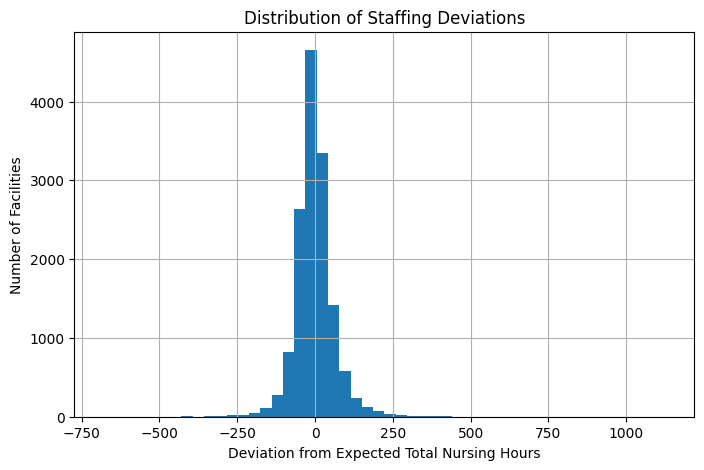

In [ ]:
plt.figure(figsize=(8,5))
df_filtered.groupby("PROVNUM")["Staffing_Deviation"].mean().hist(bins=50)
plt.xlabel("Deviation from Expected Total Nursing Hours")
plt.ylabel("Number of Facilities")
plt.title("Distribution of Staffing Deviations")
plt.show()

# Insights & What This Means

**Nurse Staffing Increases Proportionally with Facility Size**

Larger facilities require more total nurse hours due to a higher resident census. The relationship appears strongly linear, suggesting that staffing models scale predictably with facility size. The expected correlation confirms that as resident numbers increase, facilities allocate more nurse hours accordingly.

**Significant Jump from Large to Very Large Facilities (~1.3x Increase)**

Small facilities have 297.10 total nurse hours, increasing 3.1x to 926.39 for medium facilities. Large facilities rise to 1,682.59 (1.8x increase), but very large facilities show a sharper jump to 2,144.82 (1.3x increase). This suggests different staffing models, regulatory constraints, or specialized care needs in very large facilities, possibly driven by high-acuity patients, state mandates, or inefficiencies in workforce allocation.

**Facilities with Total_Nurse_HPRD > 12 Could Indicate Specialized Care or Reporting Issues**

A total of 1668 facilities exceed the expected range, which could represent cases where facilities cater to higher-acuity patients requiring more intensive nurse attention. Alternatively, state-mandated staffing minimums might be driving significantly higher nurse hours in some locations. There is also the possibility that certain facilities have data reporting inconsistencies, which would require further validation.

**Variation in Staffing Trends by Ownership Type**

For-profit facilities may operate at lower staffing levels to optimize costs, while government and nonprofit facilities often allocate more nurse hours due to different funding structures and staffing mandates. The variation in staffing levels by ownership type could reflect financial priorities, regulatory requirements, or operational efficiencies unique to each category.

**Weekend Staffing May Be Lower in Some Facilities**

Initial trends suggest that some facilities reduce nurse staffing levels on weekends, which could impact patient care. A more detailed review is required to determine whether specific states, facility types, or ownership models contribute to this pattern. Ensuring consistent staffing levels across all days is crucial for maintaining quality of care, especially in long-term care settings.

# Top 5 Overstaffed & Understaffed Facilities

In [ ]:
# Ensure unique facilities by taking the max deviation per facility
high_staffing = df_filtered.groupby("PROVNUM", group_keys=False).apply(lambda x: x.loc[x["Staffing_Deviation"].idxmax()]).reset_index(drop=True)
low_staffing = df_filtered.groupby("PROVNUM", group_keys=False).apply(lambda x: x.loc[x["Staffing_Deviation"].idxmin()]).reset_index(drop=True)

# Now sort and get the top 5 facilities
high_staffing = high_staffing.sort_values("Staffing_Deviation", ascending=False).head(5)
low_staffing = low_staffing.sort_values("Staffing_Deviation", ascending=True).head(5)

# Display as formatted tables
import IPython.display as display
from tabulate import tabulate

print("Top 5 Overstaffed Facilities:")
display.display(pd.DataFrame(high_staffing[["PROVNAME", "MDScensus", "Total_Nurse_Hours", "Staffing_Deviation", "Provider Type", "State"]]))

print("\nTop 5 Understaffed Facilities:")
display.display(pd.DataFrame(low_staffing[["PROVNAME", "MDScensus", "Total_Nurse_Hours", "Staffing_Deviation", "Provider Type", "State"]]))


<ipython-input-36-d5ac21478dca>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  high_staffing = df_filtered.groupby("PROVNUM", group_keys=False).apply(lambda x: x.loc[x["Staffing_Deviation"].idxmax()]).reset_index(drop=True)


Top 5 Overstaffed Facilities:


<ipython-input-36-d5ac21478dca>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  low_staffing = df_filtered.groupby("PROVNUM", group_keys=False).apply(lambda x: x.loc[x["Staffing_Deviation"].idxmin()]).reset_index(drop=True)


,PROVNAME,MDScensus,Total_Nurse_Hours,Staffing_Deviation,Provider Type,State
8634,ELIZABETH SETON CHILDREN'S CENTER,166,1957.23,1335.322816,Medicaid,NY
1699,"MIAMI JEWISH HEALTH SYSTEMS, INC",302,2157.70,1026.278496,Medicare and Medicaid,FL
8633,ST MARYS HOSPITAL FOR CHILDREN,128,1385.50,905.957111,Medicaid,NY
2355,NORTH DADE NURSING AND REHABILITATION CENTER,210,1643.06,856.309948,Medicare and Medicaid,FL
6586,MN VETERANS HOME MINNEAPOLIS,261,1799.25,821.432078,Medicare and Medicaid,MN



Top 5 Understaffed Facilities:


,PROVNAME,MDScensus,Total_Nurse_Hours,Staffing_Deviation,Provider Type,State
8320,THE PLAZA REHAB AND NURSING CENTER,733,1629.40,-1116.732325,Medicare and Medicaid,NY
8087,ISABELLA GERIATRIC CENTER INC,682,1678.99,-876.074455,Medicare and Medicaid,NY
7769,LINCOLN PARK CARE CENTER,522,1154.47,-801.165844,Medicare and Medicaid,NJ
8051,A HOLLY PATTERSON EXTENDED CARE FACILITY,471,990.50,-774.067974,Medicare and Medicaid,NY
8410,PINNACLE MULTICARE NURSING AND REHAB CENTER,469,988.57,-768.505117,Medicare and Medicaid,NY


<ipython-input-37-fc78762d709a>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  state_colors = plt.cm.get_cmap("tab10", len(unique_states))  # Colormap for automatic coloring


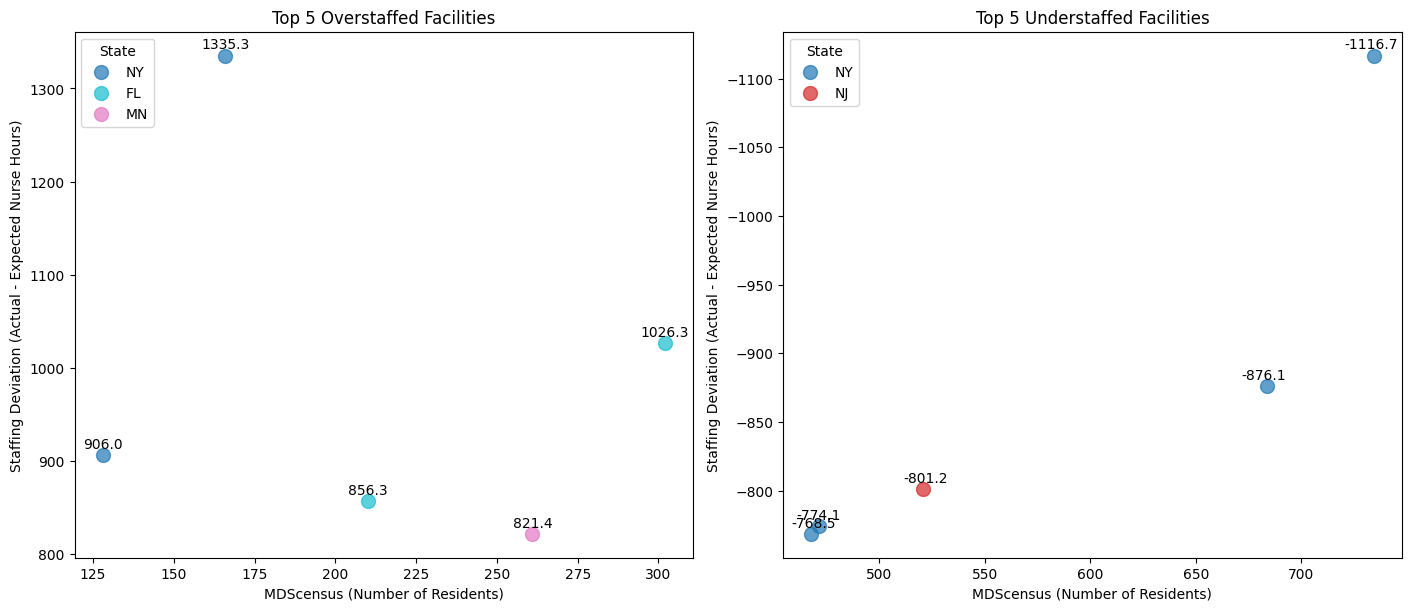

In [ ]:
import numpy as np

# Adjust figure size for better readability
fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=100, constrained_layout=True)

# Generate dynamic colors based on unique states
unique_states = list(set(high_staffing["State"].unique()) | set(low_staffing["State"].unique()))
state_colors = plt.cm.get_cmap("tab10", len(unique_states))  # Colormap for automatic coloring
state_color_map = {state: state_colors(i) for i, state in enumerate(unique_states)}

# Function to plot scatter plots
def plot_scatter(ax, data, title, invert_y=False, jitter=False):
    for state in data["State"].unique():
        subset = data[data["State"] == state]
        x_values = subset["MDScensus"] + (np.random.uniform(-2, 2, size=len(subset)) if jitter else 0)  # Apply jitter if needed
        ax.scatter(x_values, subset["Staffing_Deviation"], label=state, s=100, alpha=0.7, color=state_color_map[state])

    ax.set_title(title)
    ax.set_xlabel("MDScensus (Number of Residents)")
    ax.set_ylabel("Staffing Deviation (Actual - Expected Nurse Hours)")

    if invert_y:
        ax.invert_yaxis()  # Inverts the y-axis for under-staffed facilities

    ax.legend(title="State", loc="upper left")

    for _, row in data.iterrows():
        ax.annotate(f"{row['Staffing_Deviation']:.1f}",
                    (row["MDScensus"], row["Staffing_Deviation"]),
                    textcoords="offset points", xytext=(0,5), ha='center', fontsize=10, color="black")

# Plot for Overstaffed Facilities
plot_scatter(axes[0], high_staffing, "Top 5 Overstaffed Facilities")

# Plot for Understaffed Facilities with y-axis inverted and jitter to avoid overlapping
plot_scatter(axes[1], low_staffing, "Top 5 Understaffed Facilities", invert_y=True, jitter=True)

# Show the updated scatter plots
plt.show()

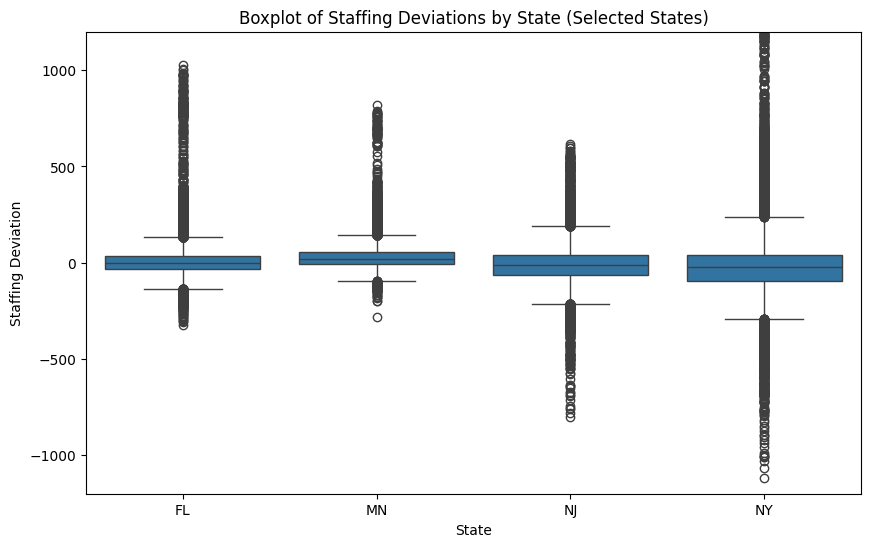

In [ ]:
import seaborn as sns

# Define states to include in the plot
selected_states = ["FL", "NY", "NJ", "MN"]

# Filter the dataset to include only the selected states
df_filtered_subset = df_filtered[df_filtered["State"].isin(selected_states)]

# Set figure size
plt.figure(figsize=(10, 6))

# Create boxplot for selected states, ensuring outliers are visible
sns.boxplot(data=df_filtered_subset, x="State", y="Staffing_Deviation", showfliers=True)

# Set y-axis range to ensure extreme values are visible
plt.ylim(-1200, 1200)

# Improve readability
plt.xlabel("State")
plt.ylabel("Staffing Deviation")
plt.title("Boxplot of Staffing Deviations by State (Selected States)")

# Show the updated boxplot
plt.show()


# Recommendation 1: Targeted Staffing Strategy for Overstaffed and Understaffed Facilities by High Deviation Staffing
**Findings from Analysis**

The analysis identified key facilities across different states with extreme staffing deviations. The five most overstaffed facilities are spread across New York (NY), Florida (FL), and Minnesota (MN), while the five most understaffed facilities are concentrated in New York (NY) and New Jersey (NJ).

**Overstaffed Facilities:**

The top facilities in NY, FL, and MN exceed expected nurse staffing levels by 800 to 1,335 nurse hours per day.
Facilities such as Elizabeth Seton Children's Center (NY) and Miami Jewish Health Systems (FL) have significantly higher staffing levels than expected.

**Understaffed Facilities:**

Facilities in NY and NJ fall short of expected nurse staffing levels by 770 to 1,116 nurse hours per day.
The Plaza Rehab and Nursing Center (NY) is the most severely understaffed facility, requiring an urgent solution.

**Actionable Sales Strategy for Clipboard Health**
1. Optimize Workforce Flexibility in Overstaffed States (NY, FL, MN)
Sales Focus: Facilities experiencing high staffing surpluses should be encouraged to transition toward more flexible workforce models using contract-based nurses instead of maintaining excessive full-time employees.
Value Proposition: Clipboard Health can help these facilities reduce labor costs by replacing some full-time roles with contract-based RNs, LPNs, and CNAs, while maintaining compliance with staffing mandates.
Target Facilities:
NY: Elizabeth Seton Children's Center, St. Mary's Hospital for Children
FL: Miami Jewish Health Systems, North Dade Nursing and Rehabilitation Center
MN: MN Veterans Home Minneapolis
2. Address Critical Staffing Shortages in Understaffed States (NY, NJ)
Sales Focus: Clipboard Health should proactively reach out to facilities in NY and NJ experiencing severe staffing shortages, as these facilities are at risk of non-compliance, regulatory penalties, and patient care challenges.
Value Proposition: The platform can offer on-demand staffing solutions to prevent penalties, ensure compliance, and improve patient outcomes.
Target Facilities:
NY: The Plaza Rehab and Nursing Center, Isabella Geriatric Center Inc, A Holly Patterson Extended Care Facility
NJ: Lincoln Park Care Center
3. Leverage State-Specific Regulations to Drive Sales
NY and NJ have stricter staffing mandates and compliance risks, making contract staffing a necessity rather than an option. Clipboard Health should position itself as a compliance partner in these regions.
FL and MN have relatively flexible staffing laws, so sales efforts should focus on cost savings and efficiency improvements through optimized contract staffing.

**Key Takeaway for Sales Leadership**

Clipboard Health can expand its market share by offering customized staffing solutions tailored to the staffing imbalances seen in each state.

In overstaffed regions, emphasize cost reduction and workforce flexibility.

*   In understaffed regions, highlight compliance risk mitigation and rapid staffing support.
*   Target high-deviation facilities first to maximize impact and revenue potential.

This strategy ensures Clipboard Health is not just a staffing provider but a workforce optimization partner that helps facilities improve efficiency while maintaining compliance and quality of care.

# High Deviation Facilities with Low Contract Utlization Rate (<20%)

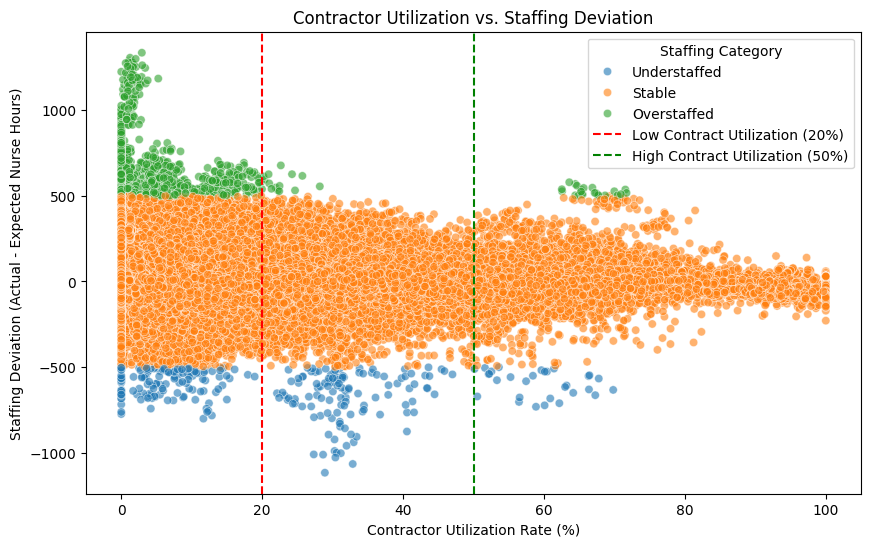

In [ ]:
import seaborn as sns

# Step 1: Calculate Contract Nurse Utilization Rate
df_filtered["Total_Contract_Hours"] = (
    df_filtered["Hrs_RNDON_ctr"] + df_filtered["Hrs_RN_ctr"] +
    df_filtered["Hrs_LPN_ctr"] + df_filtered["Hrs_CNA_ctr"] +
    df_filtered["Hrs_MedAide_ctr"] + df_filtered["Hrs_NAtrn_ctr"]
)

df_filtered["Contract_Utilization_Rate"] = (df_filtered["Total_Contract_Hours"] / df_filtered["Total_Nurse_Hours"]) * 100

# Step 2: Segment Facilities Based on Utilization and Staffing Deviation
df_filtered["Staffing_Category"] = pd.cut(
    df_filtered["Staffing_Deviation"],
    bins=[-float('inf'), -500, 500, float('inf')],
    labels=["Understaffed", "Stable", "Overstaffed"]
)

df_filtered["Contract_Category"] = pd.cut(
    df_filtered["Contract_Utilization_Rate"],
    bins=[0, 20, 50, 100],
    labels=["Low Contract Use (<20%)", "Moderate (20-50%)", "High Contract Use (>50%)"]
)

# Step 3: Scatter Plot of Contract Utilization vs. Staffing Deviation
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=df_filtered["Contract_Utilization_Rate"],
    y=df_filtered["Staffing_Deviation"],
    hue=df_filtered["Staffing_Category"],
    alpha=0.6
)
plt.axvline(20, linestyle="dashed", color="red", label="Low Contract Utilization (20%)")
plt.axvline(50, linestyle="dashed", color="green", label="High Contract Utilization (50%)")
plt.xlabel("Contractor Utilization Rate (%)")
plt.ylabel("Staffing Deviation (Actual - Expected Nurse Hours)")
plt.title("Contractor Utilization vs. Staffing Deviation")
plt.legend(title="Staffing Category")
plt.show()

In [ ]:
from IPython.display import display

# Step 1: Aggregate data at the facility level
facility_grouped = df_filtered.groupby(["PROVNAME", "State", "Provider Type"]).agg(
    MDScensus=("MDScensus", "mean"),
    Total_Nurse_Hours=("Total_Nurse_Hours", "mean"),
    Contract_Utilization_Rate=("Contract_Utilization_Rate", "mean"),  # Averaging utilization rate
    Staffing_Deviation=("Staffing_Deviation", "mean"), # Averaging deviations over time
    Total_Amount_of_Fines = ("Total Amount of Fines in Dollars", "sum")
).reset_index()

# Step 2: Apply Correct Filtering
unstable_facilities = facility_grouped[
    (facility_grouped["Contract_Utilization_Rate"] <= 20) &  # Ensuring contract utilization is <= 20%
    ((facility_grouped["Staffing_Deviation"] < -500) | (facility_grouped["Staffing_Deviation"] > 500))  # Extreme deviations
]

# **Extra Check: Ensure No Facility Has Contract Utilization Above 20%**
assert unstable_facilities["Contract_Utilization_Rate"].max() <= 20, "Error: Some facilities have Contract Utilization > 20%!"

# Step 3: Sort by Absolute Staffing Deviation (Largest Deviations First)
unstable_facilities = unstable_facilities.sort_values(by="Staffing_Deviation", key=abs, ascending=False)

# Step 4: Format Numeric Columns
unstable_facilities["MDScensus"] = unstable_facilities["MDScensus"].round(2)
unstable_facilities["Total_Nurse_Hours"] = unstable_facilities["Total_Nurse_Hours"].round(2)
unstable_facilities["Staffing_Deviation"] = unstable_facilities["Staffing_Deviation"].round(2)
unstable_facilities["Contract_Utilization_Rate"] = unstable_facilities["Contract_Utilization_Rate"].apply(lambda x: f"{round(x, 2)}%")

# Step 5: Select Relevant Columns for Display
columns_to_display = ["PROVNAME", "State", "Provider Type", "MDScensus",
                      "Total_Nurse_Hours", "Contract_Utilization_Rate", "Staffing_Deviation", "Total_Amount_of_Fines"]

# Display the formatted table
display(unstable_facilities[columns_to_display].head(10))  # Show top 10 most unstable facilities

percentage_fines_paid = ((unstable_facilities.head(10)["Total_Amount_of_Fines"].sum()) / (facility_grouped["Total_Amount_of_Fines"].sum())) * 100
total_fine_paid = unstable_facilities.head(10)["Total_Amount_of_Fines"].sum()

print(f"\nThe top 10 most unstable facilities accounted for ${total_fine_paid}({percentage_fines_paid:.2f}%) in fines paid.")

,PROVNAME,State,Provider Type,MDScensus,Total_Nurse_Hours,Contract_Utilization_Rate,Staffing_Deviation,Total_Amount_of_Fines
4016,ELIZABETH SETON CHILDREN'S CENTER,NY,Medicaid,165.52,1748.43,1.57%,1128.34,445281.20
11908,ST MARYS HOSPITAL FOR CHILDREN,NY,Medicaid,124.57,1257.60,0.0%,790.89,30550.00
8104,"MIAMI JEWISH HEALTH SYSTEMS, INC",FL,Medicare and Medicaid,299.85,1890.77,0.0%,767.42,1418949.35
8133,MIDWAY NEUROLOGICAL / REHAB CENTER,IL,Medicare and Medicaid,357.00,655.00,0.0%,-682.48,455723.60
8724,NORTH DADE NURSING AND REHABILITATION CENTER,FL,Medicare and Medicaid,214.79,1485.81,0.05%,681.11,2100689.50
8260,MN VETERANS HOME MINNEAPOLIS,MN,Medicare and Medicaid,270.98,1625.22,0.75%,610.02,1655290.00
307,ALL SAINTS HEALTHCARE SUBACUTE,CA,Medicare and Medicaid,110.67,1014.25,5.68%,599.63,15051001.42
12205,SUNSHINE CHILDREN'S HOME AND REHAB CENTER,NY,Medicare and Medicaid,98.07,944.78,0.12%,577.38,59150.00
10009,PROVIDENCE LITTLE COMP OF MARY SUBACUTE CARE CTR,CA,Medicare and Medicaid,100.78,924.47,15.62%,546.90,1075642.75



The top 10 most unstable facilities accounted for $22292277.82(0.05%) in fines paid.


# Recommendation 2: Targeting Facilities with High Staffing Instability & Low Contract Utilization

**Findings from Analysis**

The identified facilities have low contract utilization (≤20%) yet experience high staffing deviations (both overstaffing and understaffing).
These fluctuations suggest instability in workforce planning, leading to inefficiencies in scheduling and potential compliance risks.

Facilities such as Elizabeth Seton Children’s Center (NY) and North Dade Nursing & Rehabilitation Center (FL) exhibit significant staffing deviations while relying almost entirely on full-time employees.

Additionally, the top 10 most unstable facilities accounted for $22,292,277.82 (0.05%) in fines paid across all facilities, indicating that high staffing instability correlates with significant financial penalties.

**Sales Opportunity for Clipboard Health**



1.   **Strategic Targeting of High-Instability Facilities** - These facilities are prime targets as they struggle with predictable staffing levels yet are not leveraging contract staffing for flexibility.
Clipboard Health can position itself as a stabilization partner, helping them balance workforce demand with contract nurses, reducing costs and improving efficiency.
2.   **Demonstrating the Value of Contract Staffing** -
Facilities with extreme overstaffing incur unnecessary labor costs; introducing contract staffing allows them to adjust workforce levels dynamically rather than maintaining surplus full-time staff.
Understaffed facilities risk compliance issues and decreased quality of care; on-demand contract staffing can prevent critical workforce shortages and regulatory penalties.
3. **Actionable Next Steps for Sales Team** -
Prioritize outreach to facilities with the highest instability scores and low contract utilization.
Develop data-backed case studies demonstrating how other facilities have successfully reduced workforce instability using Clipboard Health’s contract staffing model.
Customize sales conversations based on facility size and provider type, ensuring tailored solutions for long-term workforce optimization.


**Key Takeaway for Clipboard Health**

Clipboard Health can pursue these facilities as top sales targets given their high instability and low contract utilization rate. By demonstrating how contract staffing can improve efficiency and adaptability, Clipboard Health can establish itself as a crucial partner for workforce stability and compliance.

# Facilities Non-Compliant with CMS Regulations

In [ ]:
from IPython.display import display

# Define CMS-recommended staffing levels
cms_min_hprd = {
    "RN": 0.55,
    "LPN/Other": 0.48,
    "CNA": 2.45,
    "Total": 3.48
}

# Ensure required columns exist
required_columns = ["PROVNAME", "State", "Provider Type", "MDScensus", "Total_Nurse_Hours"]
missing_columns = [col for col in required_columns if col not in df_filtered.columns]

if not missing_columns:
    # Aggregate data at the facility level
    facility_level = df_filtered.groupby(["PROVNAME", "State", "Provider Type"], as_index=False).agg({
        "MDScensus": "mean",  # Average daily census over time
        "Total_Nurse_Hours": "sum"  # Sum of total nurse hours
    })

    # Calculate HPRD at the facility level
    facility_level["HPRD"] = facility_level["Total_Nurse_Hours"] / facility_level["MDScensus"]

    # Flag facilities that fall below the CMS threshold
    facility_level["CMS_Non_Compliant"] = facility_level["HPRD"] < cms_min_hprd["Total"]

    # Filter non-compliant facilities
    non_compliant_facilities = facility_level[facility_level["CMS_Non_Compliant"]].copy()

    # Ensure no missing values in key fields
    non_compliant_facilities = non_compliant_facilities.dropna(subset=["HPRD", "Total_Nurse_Hours", "MDScensus"])

    # Sort by lowest HPRD to prioritize most non-compliant
    non_compliant_facilities = non_compliant_facilities.sort_values(by="HPRD")

    # Select relevant columns and round values
    columns_to_display = ["PROVNAME", "State", "Provider Type", "MDScensus", "Total_Nurse_Hours", "HPRD"]
    non_compliant_facilities = non_compliant_facilities[columns_to_display]
    non_compliant_facilities["HPRD"] = non_compliant_facilities["HPRD"].round(2)  # Limit to 2 decimals
    non_compliant_facilities["Total_Nurse_Hours"] = non_compliant_facilities["Total_Nurse_Hours"].round(2)
    non_compliant_facilities["MDScensus"] = non_compliant_facilities["MDScensus"].round(2)

    # Display the total count of non-compliant facilities
    print(f"Total Non-Compliant Facilities: {non_compliant_facilities.shape[0]}")

    # Display the table
    print("Non-Compliant Facilities (Aggregated by Facility Name)")
    display(non_compliant_facilities.head(20))  # Show top 20 non-compliant facilities
else:
    print(f"Missing required columns: {missing_columns}")


Total Non-Compliant Facilities: 4
Non-Compliant Facilities (Aggregated by Facility Name)


,PROVNAME,State,Provider Type,MDScensus,Total_Nurse_Hours,HPRD
8133,MIDWAY NEUROLOGICAL / REHAB CENTER,IL,Medicare and Medicaid,357.0,655.00,1.83
13959,WESTVIEW NURSING HOME,MO,Medicare and Medicaid,57.0,125.75,2.21
471,ANDREW RESIDENCE,MN,Medicaid,210.0,503.25,2.40
1559,BETHANY HOME,IA,Medicare and Medicaid,63.0,164.58,2.61


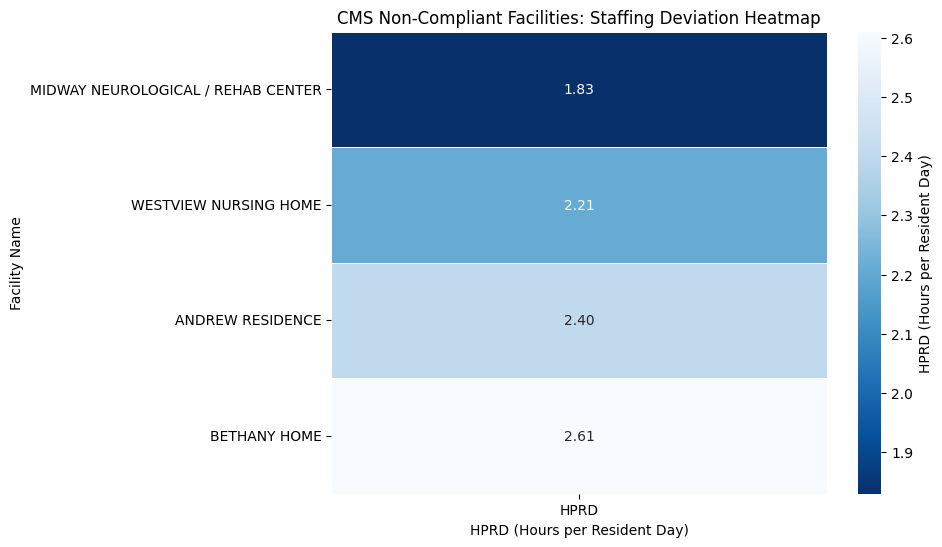

In [ ]:
# Ensure HPRD column is numeric and drop NaNs
non_compliant_facilities = non_compliant_facilities.dropna(subset=["HPRD"])
non_compliant_facilities["HPRD"] = pd.to_numeric(non_compliant_facilities["HPRD"], errors='coerce')

# Sort by lowest HPRD for better visualization
non_compliant_facilities = non_compliant_facilities.sort_values(by="HPRD", ascending=True)

# Ensure unique facility names for heatmap index
heatmap_data = non_compliant_facilities.set_index("PROVNAME")[["HPRD"]]

# Plot the heatmap
plt.figure(figsize=(8,6))  # Adjust figure size for readability
sns.heatmap(heatmap_data, cmap="Blues_r", annot=True, linewidths=0.5, fmt=".2f",
            cbar_kws={'label': "HPRD (Hours per Resident Day)"},
            vmin=heatmap_data.min().values[0], vmax=heatmap_data.max().values[0])  # Ensures correct scaling

# Formatting
plt.xlabel("HPRD (Hours per Resident Day)")
plt.ylabel("Facility Name")
plt.title("CMS Non-Compliant Facilities: Staffing Deviation Heatmap")
# Show the fixed heatmap
plt.show()

# Recommendation 3: Addressing Non-Compliant Facilities with CMS Staffing Benchmarks

**Findings from Analysis**

The heatmap highlights facilities that fail to meet the CMS minimum staffing requirement of 4.1 Hours per Resident Day (HPRD). These flagged facilities exhibit significant staffing gaps, putting them at risk of penalties, regulatory scrutiny, and reduced patient care quality.

**Severely Understaffed Facilities**


*   Midway Neurological / Rehab Center (IL) - 1.83 HPRD
*   Westview Nursing Home (MO) - 2.21 HPRD
*   Andrew Residence (MN) - 2.40 HPRD
*   Bethany Home (IA) - 2.61 HPRD

These facilities fall significantly below the CMS-recommended threshold of 4.1 HPRD, which increases the risk of fines, citations, and loss of Medicare/Medicaid funding.

**Sales Opportunity for Clipboard Health**
1. Target Facilities with the Largest Staffing Gaps
Clipboard Health can focus on facilities with the lowest HPRD (under 3.0) as priority clients since they have the most urgent need to increase staffing levels to avoid non-compliance.

2. Highlight Risk Mitigation
Understaffed facilities face CMS penalties and increased patient safety risks. Clipboard Health can position contract nursing staff as a rapid compliance solution to help them avoid fines and improve care standards.

3. Flexible Staffing Model to Meet CMS Benchmarks
Many of these facilities lack consistent staffing levels. Instead of struggling to recruit full-time staff, Clipboard Health can offer a flexible, on-demand workforce to adjust to CMS mandates without long-term hiring costs.

**Key Takeaway for Sales Leadership**

By proactively engaging with these non-compliant facilities, Clipboard Health can present contract staffing as an immediate solution to help them avoid penalties, improve compliance, and maintain high-quality patient care while keeping labor costs flexible.

# Parameters of Staffing Violations

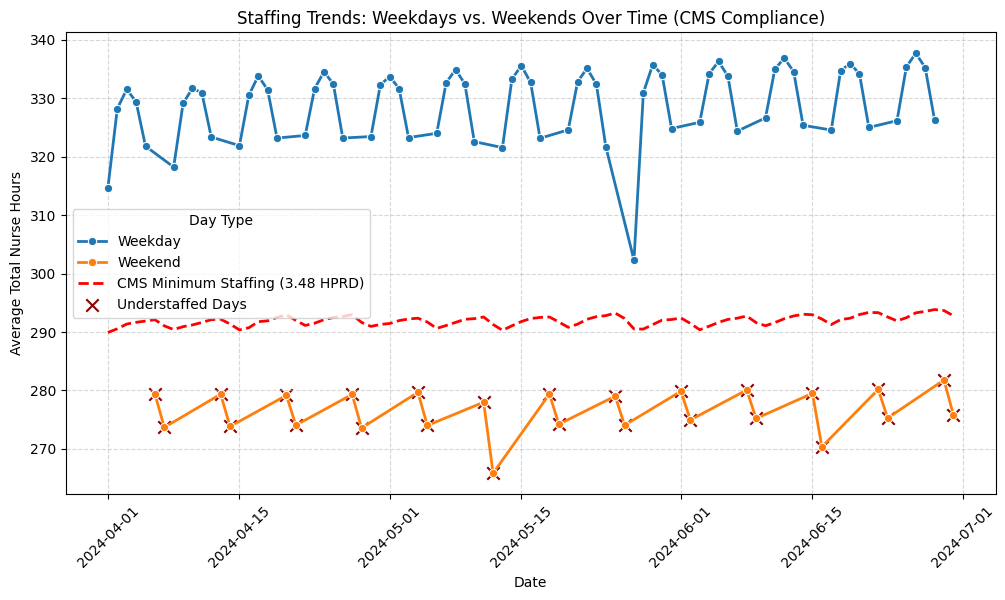

In [ ]:
# Ensure WorkDate is in datetime format
df_filtered["WorkDate"] = pd.to_datetime(df_filtered["WorkDate"], format="%Y%m%d")

# Identify weekends (Saturday & Sunday)
df_filtered["Is_Weekend"] = df_filtered["WorkDate"].dt.dayofweek.isin([5, 6])  # 5=Sat, 6=Sun

# Calculate CMS required staffing per day
df_filtered["CMS_Threshold"] = df_filtered["MDScensus"] * 3.48

# Aggregate staffing trends per day, separately for weekdays and weekends
staffing_trends = df_filtered.groupby(["WorkDate", "Is_Weekend"]).agg({
    "Total_Nurse_Hours": "mean",  # Average total nurse hours
    "CMS_Threshold": "mean"  # Average required staffing level
}).reset_index()

# Map weekday/weekend labels
staffing_trends["Day Type"] = staffing_trends["Is_Weekend"].map({False: "Weekday", True: "Weekend"})

# Plot staffing trends
plt.figure(figsize=(12, 6))

# Plot weekday and weekend staffing trends
sns.lineplot(data=staffing_trends, x="WorkDate", y="Total_Nurse_Hours", hue="Day Type", marker="o", linewidth=2)

# Add CMS required staffing threshold as a dashed red line
plt.plot(staffing_trends["WorkDate"], staffing_trends["CMS_Threshold"],
         color="red", linestyle="dashed", linewidth=2, label="CMS Minimum Staffing (3.48 HPRD)")

# Highlight non-compliant days
understaffed_days = staffing_trends[staffing_trends["Total_Nurse_Hours"] < staffing_trends["CMS_Threshold"]]
plt.scatter(understaffed_days["WorkDate"], understaffed_days["Total_Nurse_Hours"],
            color="darkred", label="Understaffed Days", marker="x", s=80)

# Formatting
plt.xlabel("Date")
plt.ylabel("Average Total Nurse Hours")
plt.title("Staffing Trends: Weekdays vs. Weekends Over Time (CMS Compliance)")
plt.legend(title="Day Type")
plt.grid(True, linestyle="--", alpha=0.5)
plt.xticks(rotation=45)

# Show the final refined plot
plt.show()

In [ ]:
from IPython.display import display

# Ensure WorkDate is in datetime format
df_filtered["WorkDate"] = pd.to_datetime(df_filtered["WorkDate"], format="%Y%m%d")

# Define Q2 2024 date range
q2_dates = pd.date_range(start="2024-04-01", end="2024-06-30")

# Create a reference table to ensure all facilities have complete date coverage
facility_dates = pd.MultiIndex.from_product([df_filtered["PROVNUM"].unique(), q2_dates],
                                            names=["PROVNUM", "WorkDate"]).to_frame(index=False)

# Merge with original data to ensure all facilities are tracked properly
facility_daily = facility_dates.merge(df_filtered, on=["PROVNUM", "WorkDate"], how="left")

# Fill missing Total Nurse Hours as 0 (assuming they didn't report)
facility_daily["Total_Nurse_Hours"] = facility_daily["Total_Nurse_Hours"].fillna(0)

# Calculate CMS required staffing per day (3.48 HPRD)
facility_daily["CMS_Threshold"] = facility_daily["MDScensus"] * 3.48

# Flag whether the facility was non-compliant each day
facility_daily["Understaffed"] = facility_daily["Total_Nurse_Hours"] < facility_daily["CMS_Threshold"]

# Corrected Total Tracked Days Calculation
facility_violations = facility_daily.groupby("PROVNUM").agg(
    Total_Tracked_Days=("WorkDate", "count"),  # This should now be exactly 91 for all facilities
    Understaffed_Days=("Understaffed", "sum")  # Sum of days facility was non-compliant
).reset_index()

# Merge facility details correctly
facility_violations = facility_violations.merge(
    df_filtered[["PROVNUM", "PROVNAME", "State", "Provider Type"]].drop_duplicates("PROVNUM"),
    on="PROVNUM",
    how="left"
)

# Calculate violation percentage correctly
facility_violations["Violation_Percentage"] = (facility_violations["Understaffed_Days"] /
                                               facility_violations["Total_Tracked_Days"]) * 100

# Sort by highest violation percentage
facility_violations = facility_violations.sort_values(by="Violation_Percentage", ascending=False)

# Display top 20 most severe violators
display(facility_violations.head(20))

,PROVNUM,Total_Tracked_Days,Understaffed_Days,PROVNAME,State,Provider Type,Violation_Percentage
2568,115541,91,91,CROSSVIEW CARE CENTER,GA,Medicare and Medicaid,100.0
12299,495347,91,91,CONSULATE HEALTH CARE OF WINDSOR,VA,Medicare and Medicaid,100.0
1506,075264,91,91,TOUCHPOINTS AT BLOOMFIELD,CT,Medicare and Medicaid,100.0
8433,335613,91,91,THE BAPTIST HOME AT BROOKMEADE,NY,Medicare and Medicaid,100.0
12296,495343,91,91,GREENE ACRES REHABILITATION AND NURSING,VA,Medicare and Medicaid,100.0
14137,676116,91,91,FOCUSED CARE AT WESTWOOD,TX,Medicare and Medicaid,100.0
13968,675892,91,91,GULF POINTE PLAZA,TX,Medicare and Medicaid,100.0
3299,145947,91,91,APERION CARE MIDLOTHIAN,IL,Medicare and Medicaid,100.0
2914,145278,91,91,"CITADEL OF STERLING,THE",IL,Medicare and Medicaid,100.0
12286,495331,91,91,GRAYSON REHABILITATION AND HEALTH CARE CENTER,VA,Medicare and Medicaid,100.0


<ipython-input-45-ea6623c260d8>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=state_violations, x="State", y="Violation_Percentage", palette="Blues_r")
<ipython-input-45-ea6623c260d8>:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{int(tick)}%" for tick in ax.get_yticks()])


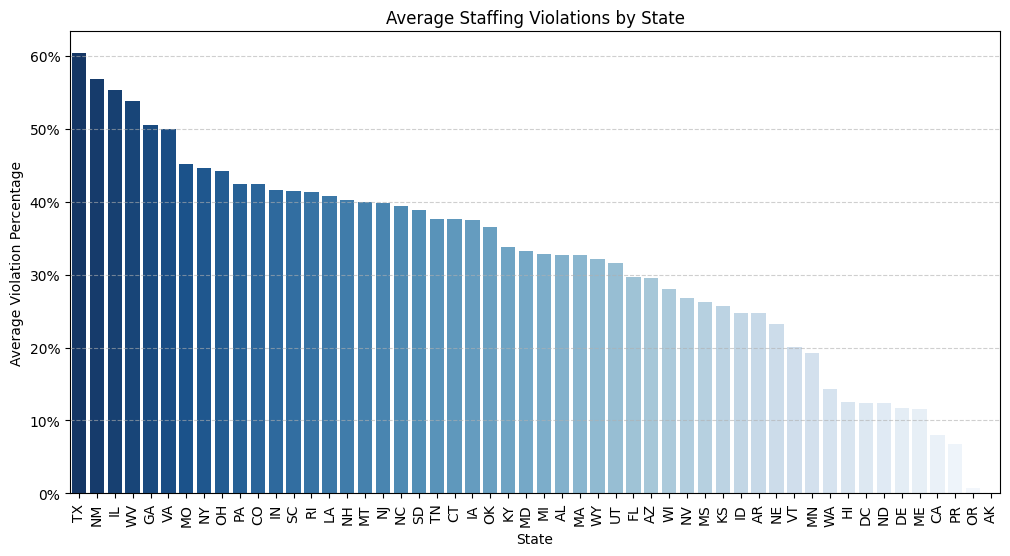

In [ ]:
# Aggregate by state
state_violations = facility_violations.groupby("State")["Violation_Percentage"].mean().reset_index()

# Sort states by highest average violation percentage
state_violations = state_violations.sort_values(by="Violation_Percentage", ascending=False)

# Plot heatmap of violations by state with inverted color scheme
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=state_violations, x="State", y="Violation_Percentage", palette="Blues_r")
plt.xticks(rotation=90)
plt.xlabel("State")
plt.ylabel("Average Violation Percentage")
plt.title("Average Staffing Violations by State")
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Format y-axis to show percentages
ax.set_yticklabels([f"{int(tick)}%" for tick in ax.get_yticks()])

# Show the refined plot
plt.show()

<ipython-input-53-ae48de6916e2>:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  size_violations = df_filtered.groupby("Facility_Size")["Understaffed"].mean().reset_index()
<ipython-input-53-ae48de6916e2>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=size_violations, x="Facility_Size", y="Understaffed", palette="coolwarm")


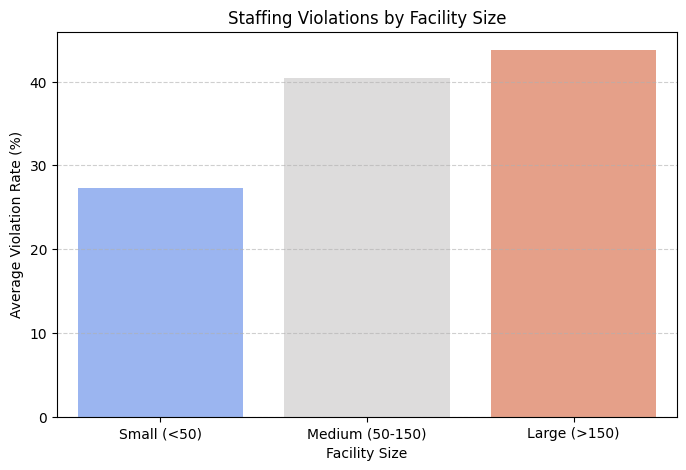


Average Violation Rates by Facility Size:
  Facility_Size  Understaffed
    Small (<50)         27.30
Medium (50-150)         40.44
   Large (>150)         43.76


In [ ]:
# Categorize facilities based on MDScensus (Resident Census)
df_filtered["Facility_Size"] = pd.cut(
    df_filtered["MDScensus"],
    bins=[0, 50, 150, float("inf")],
    labels=["Small (<50)", "Medium (50-150)", "Large (>150)"]
)

# Calculate average violation rates per facility size category
size_violations = df_filtered.groupby("Facility_Size")["Understaffed"].mean().reset_index()

# Convert violation rate to percentage
size_violations["Understaffed"] = (size_violations["Understaffed"] * 100).round(2)

# Plot the bar chart
plt.figure(figsize=(8, 5))
sns.barplot(data=size_violations, x="Facility_Size", y="Understaffed", palette="coolwarm")

# Formatting
plt.xlabel("Facility Size")
plt.ylabel("Average Violation Rate (%)")
plt.title("Staffing Violations by Facility Size")
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Show plot
plt.show()

# Display DataFrame with violation rates
print("\nAverage Violation Rates by Facility Size:")
print(size_violations.to_string(index=False))

In [ ]:
# Ensure WorkDate is in datetime format
df_filtered["WorkDate"] = pd.to_datetime(df_filtered["WorkDate"], format="%Y%m%d")

# Define first and second half of the quarter
midpoint_date = pd.to_datetime("2024-05-15")

df_filtered["CMS_Threshold"] = df_filtered["MDScensus"] * 3.48
df_filtered["Understaffed"] = (df_filtered["Total_Nurse_Hours"] < df_filtered["CMS_Threshold"]).astype(int)

# First half staffing compliance
first_half = df_filtered[df_filtered["WorkDate"] <= midpoint_date].groupby("PROVNAME")["Understaffed"].mean().reset_index()
first_half.columns = ["PROVNAME", "Violation_Rate_First_Half"]

# Second half staffing compliance
second_half = df_filtered[df_filtered["WorkDate"] > midpoint_date].groupby("PROVNAME")["Understaffed"].mean().reset_index()
second_half.columns = ["PROVNAME", "Violation_Rate_Second_Half"]

# Merge both halves
facility_trend = first_half.merge(second_half, on="PROVNAME", how="inner")

# Determine status of each facility
def categorize_trend(row):
    if row["Violation_Rate_Second_Half"] > row["Violation_Rate_First_Half"]:
        return "Getting Worse"
    elif row["Violation_Rate_Second_Half"] < row["Violation_Rate_First_Half"]:
        return "Getting Better"
    elif row["Violation_Rate_First_Half"] == row["Violation_Rate_Second_Half"] and row["Violation_Rate_First_Half"] > 0:
        return "Consistently Bad"
    else:
        return "Consistently Good"

facility_trend["Trend"] = facility_trend.apply(categorize_trend, axis=1)

# Summary of trends
facility_trend_summary = facility_trend["Trend"].value_counts().reset_index()
facility_trend_summary.columns = ["Trend Type", "Number of Facilities"]

# Format percentages
facility_trend["Violation_Rate_First_Half"] = (facility_trend["Violation_Rate_First_Half"] * 100).round(2)
facility_trend["Violation_Rate_Second_Half"] = (facility_trend["Violation_Rate_Second_Half"] * 100).round(2)

# Show summary of trends
print("\nFacility Staffing Trends Over Time:")
print(facility_trend_summary.to_string(index=False))

# Show top 15 facilities with worsening trends
facility_trend_worst = facility_trend[facility_trend["Trend"] == "Getting Worse"].sort_values(by="Violation_Rate_Second_Half", ascending=False).head(15)
# Show top 15 facilities with consistently bad trend
facility_consistently_bad = facility_trend[facility_trend["Trend"] == "Consistently Bad"].sort_values(by="Violation_Rate_Second_Half", ascending=False).head(15)


print("\nTop 15 Facilities with Worsening Trends:")
print(facility_trend_worst.to_string(index=False))


print("----------------------------------------------------------------------------------------------------------------------")
print("\nTop 15 Facilities with Consistently Bad Trend:")
print(facility_consistently_bad.to_string(index=False))


Facility Staffing Trends Over Time:
       Trend Type  Number of Facilities
    Getting Worse                  6123
   Getting Better                  5400
Consistently Good                  2098
 Consistently Bad                   633

Top 15 Facilities with Worsening Trends:
                                          PROVNAME  Violation_Rate_First_Half  Violation_Rate_Second_Half         Trend
                                        24TH PLACE                      95.45                       100.0 Getting Worse
                   LOFT REHAB OF ROCK SPRINGS, THE                      82.22                       100.0 Getting Worse
              LE REVE REHABILITATION & MEMORY CARE                      88.89                       100.0 Getting Worse
                                         LEE MANOR                      97.78                       100.0 Getting Worse
                             LEGACY ON 10TH AVENUE                      96.77                       100.0 Getting Worse
 

In [ ]:
pip install pmdarima

## 90 Day Staffing Forecast

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

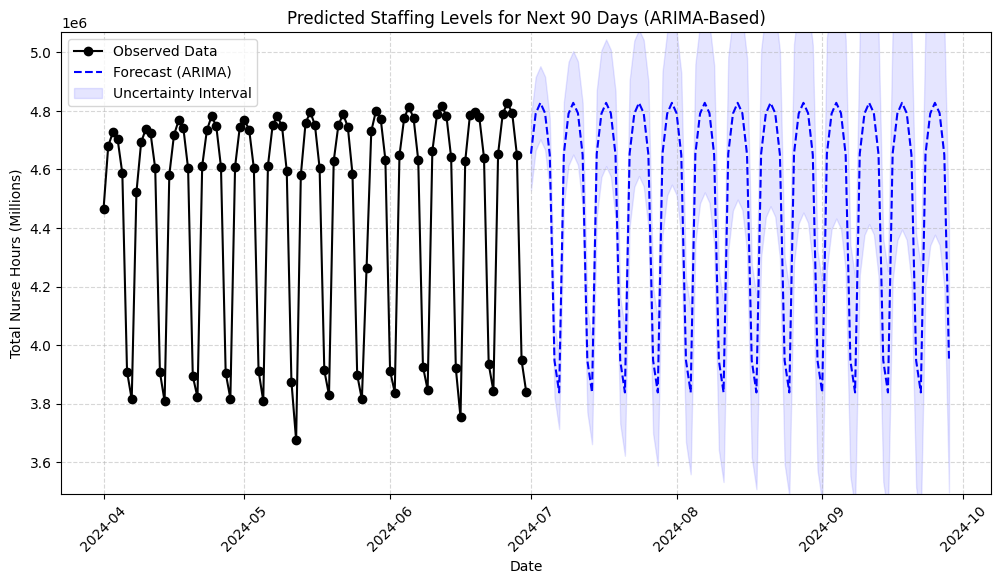

In [ ]:
import statsmodels.api as sm
import pmdarima as pm  # For Auto ARIMA

# Step 1: Aggregate Total Nurse Hours & Resident Census Per Day
daily_staffing = df_filtered.groupby("WorkDate").agg(
    Total_Nurse_Hours=("Total_Nurse_Hours", "sum"),
    Total_Residents=("MDScensus", "sum")
).reset_index()

# Step 2: Compute CMS Minimum Staffing Requirement Per Day (Dynamic)
daily_staffing["CMS_Threshold"] = daily_staffing["Total_Residents"] * 3.48

# Step 3: Convert WorkDate to datetime format
daily_staffing["WorkDate"] = pd.to_datetime(daily_staffing["WorkDate"], format="%Y%m%d")
daily_staffing.set_index("WorkDate", inplace=True)

# Step 4: Fit Auto ARIMA Model (automatically selects best parameters)
arima_model = pm.auto_arima(daily_staffing["Total_Nurse_Hours"], seasonal=True, m=7, stepwise=True)

# Step 5: Generate Future Predictions (Next 90 Days)
future_dates = pd.date_range(start=daily_staffing.index[-1] + pd.Timedelta(days=1), periods=90, freq="D")
forecast_values, conf_int = arima_model.predict(n_periods=90, return_conf_int=True)

# Step 6: Compute Future CMS Minimum Threshold Using Historical Average Census
avg_future_census = daily_staffing["Total_Residents"].mean()
cms_future_threshold = avg_future_census * 3.48  # Estimated future CMS staffing requirement

# Step 7: Adjust Y-Axis Scale Based on Real Data
y_min = daily_staffing["Total_Nurse_Hours"].min() * 0.95
y_max = daily_staffing["Total_Nurse_Hours"].max() * 1.05

# Step 8: Plot the Forecast & CMS Minimum Line
plt.figure(figsize=(12, 6))
plt.plot(daily_staffing.index, daily_staffing["Total_Nurse_Hours"], label="Observed Data", marker="o", color="black")
plt.plot(future_dates, forecast_values, label="Forecast (ARIMA)", linestyle="dashed", color="blue")

# Plot Confidence Interval
plt.fill_between(future_dates, conf_int[:, 0], conf_int[:, 1], color="blue", alpha=0.10, label="Uncertainty Interval")

# Formatting & Labels
plt.ylim(y_min, y_max)
plt.xlabel("Date")
plt.ylabel("Total Nurse Hours (Millions)")
plt.title("Predicted Staffing Levels for Next 90 Days (ARIMA-Based)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.xticks(rotation=45)

# Show the final fixed forecast
plt.show()

# Recommendation 4: Targeted Intervention for High-Risk Facilities Based on Trends & Facility Size

**Findings from Data Analysis and Visualizations**

Based on the insights from staffing trends, facility-level violations, and forecasting models, the following key patterns emerge:

**Facilities with Consistently Worsening Trends:**

6,123 facilities have shown a worsening staffing trend in the second half of the quarter.
633 facilities have been consistently non-compliant, maintaining 100% violation rates across both halves.

**High-Risk Facilities Based on Facility Size:**

Large facilities (>150 residents) have the highest violation rate (43%).
Medium-sized facilities (50-150 residents) also show high violation rates (41%).
Smaller facilities (<50 residents) have significantly lower violation rates (28%).

**Predicted Staffing Trends Indicate Persistent Shortages:**

Forecasting suggests continued seasonal fluctuations, with high uncertainty in future staffing trends.

Many facilities consistently fall below CMS staffing benchmarks (3.48 HPRD).
Data-Driven Recommendation

Given these insights, the sales team should prioritize engagement with large and medium-sized facilities that are either:

*   Getting Worse (declining staffing compliance).
*   Consistently Bad (100% non-compliance in both halves of the quarter).

**Tailored Solution Approach:**

1. For Large Facilities (>150 residents): Focus on facilities where violation rates exceed 40%. These facilities handle a high patient load and often struggle with long-term staffing stability. Emphasize scalable workforce solutions, offering consistent staffing partnerships to mitigate non-compliance risks.

2. For Medium Facilities (50-150 residents): Highlight the risk of growing non-compliance and offer predictive workforce planning services, leveraging AI-driven staffing models to forecast future shortages.

3. For Small Facilities (<50 residents): Despite lower violation rates, some small facilities still struggle with compliance. Target those with worsening trends to prevent long-term risks.

Key Sales Takeaways

1. Prioritize facilities with worsening staffing trends and 100% violation rates.
2. Leverage AI-driven forecasting tools to showcase predictive workforce solutions.
3.  Tailor staffing solutions based on facility size—scalable solutions for large facilities, predictive planning for medium facilities, and intervention for small but deteriorating facilities.
4. Position Clipboard Health as a long-term partner that proactively prevents CMS violations and ensures compliance.